In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

1. Import data.

In [ ]:
df = pd.read_excel("/Users/tungdiesel/Desktop/datadriven/onlineretail.xlsx")     
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])   
df['Month'] = df['InvoiceDate'].dt.month
data = df[(df['InvoiceDate'].dt.month >= 2) & (df['InvoiceDate'].dt.month <= 6) & (df['Quantity'] > 0)] # lọc tháng 2 -6, chỉ lấy các giá trị dượng ở cột Quantity
data["OrderValue"] = data["UnitPrice"] * data["Quantity"] 
display(data)

/var/folders/h4/m7zhf0zn3ns7pgr7n020rz3m0000gn/T/ipykernel_60749/3578890733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["OrderValue"] = data["UnitPrice"] * data["Quantity"]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,OrderValue
77628,542776,21671,RED SPOT CERAMIC DRAWER KNOB,48,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,60.00
77629,542776,21668,RED STRIPE CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77630,542776,21670,BLUE SPOT CERAMIC DRAWER KNOB,12,2011-02-01 08:23:00,1.25,15240.0,United Kingdom,2,15.00
77631,542776,17013D,ORIGAMI ROSE INCENSE IN TUBE,96,2011-02-01 08:23:00,0.42,15240.0,United Kingdom,2,40.32
77632,542776,17096,ASSORTED LAQUERED INCENSE HOLDERS,48,2011-02-01 08:23:00,0.21,15240.0,United Kingdom,2,10.08
...,...,...,...,...,...,...,...,...,...,...
245898,558637,22032,BOTANICAL LILY GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245899,558637,22028,PENNY FARTHING BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245900,558637,22033,BOTANICAL ROSE GREETING CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04
245901,558637,22029,SPACEBOY BIRTHDAY CARD,12,2011-06-30 20:08:00,0.42,17891.0,United Kingdom,6,5.04


2. Tìm các mặt hàng bán chạy nhất.

In [19]:
num_items = data['Description'].nunique()   # đếm số lượng các mặt hàng
print(num_items)



3306


In [20]:
# tính tổng số lượng các mặt hàng đã bán
item_sales = (
    data.groupby('Description')  # nhóm theo tên hàng
      ['Quantity']             # chọn cột Quantity
      .sum()                   # tính tổng
      .sort_values(ascending=False)  # sắp xếp
)

top_items = item_sales.head(10) # lấy 10 mặt hàng bán nhiều nhất

other_total = item_sales.iloc[10:].sum() # tính tổng số lượng của các loại hàng còn lại

final_sales = pd.concat([top_items, pd.Series({'Other': other_total})]) # tạo series mới gồm top 10 và nhóm 'Other'
print(final_sales)

WORLD WAR 2 GLIDERS ASSTD DESIGNS       24716
JUMBO BAG RED RETROSPOT                 18121
ASSORTED COLOURS SILK FAN               15360
SMALL POPCORN HOLDER                    15314
PACK OF 72 RETROSPOT CAKE CASES         14491
WHITE HANGING HEART T-LIGHT HOLDER      13435
PACK OF 12 LONDON TISSUES               12501
PACK OF 60 PINK PAISLEY CAKE CASES      12342
ASSORTED COLOUR BIRD ORNAMENT           11513
VICTORIAN GLASS HANGING T-LIGHT         10527
Other                                 1618071
dtype: int64


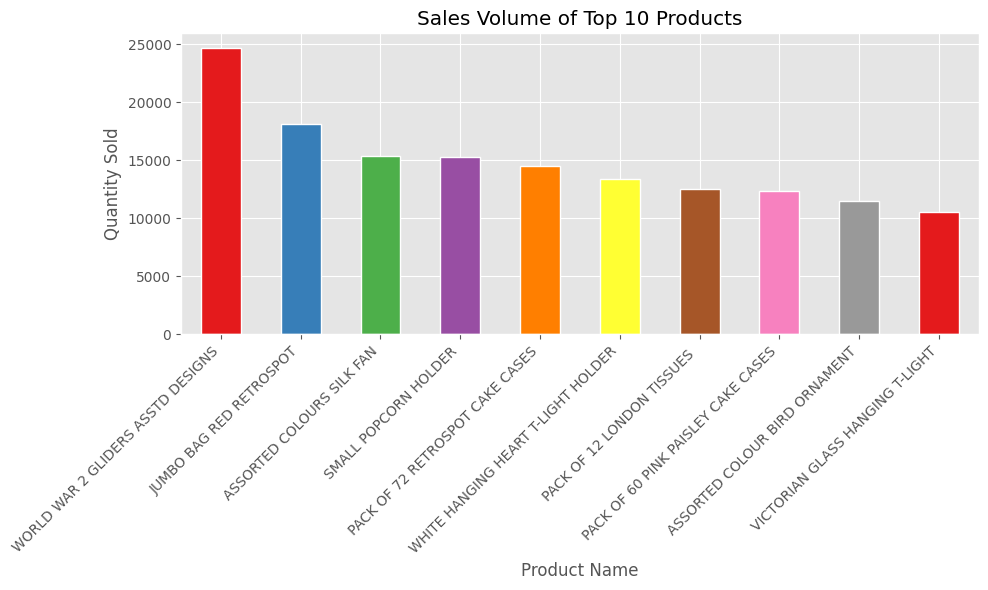

In [21]:
plt.style.use('ggplot') #chọn theme biểu đồ

colors = sns.color_palette('Set1', n_colors=10) #chọn palette màu

top_items.plot(
    kind='bar',             # loại biểu đồ cột
    figsize=(10, 6),        # size 10x6 inch
    color=colors,           # chọn màu
    edgecolor='white',      # màu viện trắng
    linewidth=1
)
plt.title('Sales Volume of Top 10 Products')
plt.xlabel('Product Name')
plt.ylabel('Quantity Sold')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục X cho dễ đọc, căn chỉnh nhãn theo chiều ngang về phía bên phải (ha = horizontalalignment).
plt.tight_layout()  # Điều chỉnh layout tự động
plt.show()

3. Tính giá trị mua hàng và tần suất mua hàng trung bình.

3.1. Tính giá trị mua hàng trung bình.

In [25]:

# gộp các mã sản phẩm (StockCode) theo đơn hàng
stockcode_joined = (
    data.groupby('InvoiceNo')['StockCode']          # nhóm theo cột InvoiceNo, sau đó truy cập cột Stockcode
    .apply(lambda x: ', '.join(x.astype(str)))      # lấy các StockCode cho về dạng chuỗi, rồi viết liền thành 1 dòng phân cách bởi dấu ","
    .reset_index(name='StockCodes')                 # trả về cột StockCode không phải dạng index
)

# gộp các mô tả sản phẩm (Description) theo đơn hàng, tương tự như đoạn trên
description_joined = (
    data.groupby('InvoiceNo')['Description']
    .apply(lambda x: ', '.join(x.astype(str)))
    .reset_index(name='Descriptions')
)

# tổng giá trị hóa đơn
invoice_total = (
    data.groupby('InvoiceNo')['OrderValue'].sum()
    .reset_index(name='TotalOrderValue')
)
# số lượng sản phẩm trong mỗi hóa đơn
item_counts = (
    data.groupby('InvoiceNo').size()
    .reset_index(name='ItemCount')
)

invoice_summary = (
    data[['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country']]
    .drop_duplicates(subset='InvoiceNo')
)

# gộp tất cả lại
invoice_summary = (
    invoice_summary
    .merge(invoice_total, on='InvoiceNo', how='left')
    .merge(item_counts, on='InvoiceNo', how='left')
    .merge(stockcode_joined, on='InvoiceNo', how='left')
    .merge(description_joined, on='InvoiceNo', how='left')
)

# sắp xếp theo thời gian (tăng dần)
invoice_summary = (
    invoice_summary
    .sort_values(by='InvoiceDate', ascending=True)
    
)

# sửa index lại để bắt đầu từ 1
invoice_summary.index = range(1, len(invoice_summary) + 1)

# Xem kết quả
display(invoice_summary.tail(20))


,InvoiceNo,InvoiceDate,CustomerID,Country,TotalOrderValue,ItemCount,StockCodes,Descriptions
7263,558616,2011-06-30 16:22:00,16045.0,United Kingdom,269.40,16,"22960, 22993, 22961, 22907, 22469, 22171, 7145...","JAM MAKING SET WITH JARS, SET OF 4 PANTRY JELL..."
7264,558619,2011-06-30 16:28:00,14401.0,United Kingdom,316.70,14,"21382, 22287, 22286, 85194S, 23210, 23321, 233...","SET/4 SPRING FLOWER DECORATION, DECORATION WOB..."
7265,558620,2011-06-30 16:39:00,15584.0,United Kingdom,154.65,36,"21257, 21259, 21931, 22411, 85099C, 23202, 850...","VICTORIAN SEWING BOX MEDIUM, VICTORIAN SEWING ..."
7266,558621,2011-06-30 16:43:00,13745.0,United Kingdom,300.04,25,"21382, 75172, 22035, 21507, 21508, 22023, 2203...","SET/4 SPRING FLOWER DECORATION, PAINTED SEA SH..."
7267,558622,2011-06-30 16:51:00,16357.0,United Kingdom,120.05,5,"47566, 21755, 21936, 21643, 23118","PARTY BUNTING, LOVE BUILDING BLOCK WORD, RED R..."
7268,558623,2011-06-30 16:52:00,12395.0,Belgium,163.90,10,"22326, 22661, 21559, 21561, 23307, 22726, 2272...","ROUND SNACK BOXES SET OF4 WOODLAND , CHARLOTTE..."
7269,558624,2011-06-30 17:16:00,14560.0,United Kingdom,17.00,1,22624,IVORY KITCHEN SCALES
7270,558625,2011-06-30 17:29:00,14132.0,United Kingdom,301.06,18,"20761, 20762, 20765, 23191, 21224, 21221, 2203...","BLUE PAISLEY SKETCHBOOK, GREEN FERN SKETCHBOOK..."
7271,558626,2011-06-30 17:34:00,12569.0,Germany,95.28,6,"23242, 23180, 22396, 22403, 22398, POST","TREASURE TIN BUFFALO BILL , MUM'S KITCHEN CLOC..."
7272,558627,2011-06-30 17:40:00,14711.0,United Kingdom,311.86,6,"22823, 22827, 23020, 23014, 23241, 23168","CHEST NATURAL WOOD 20 DRAWERS, RUSTIC SEVENTE..."


In [26]:
print(invoice_summary['TotalOrderValue'].describe()) #bảng summary giống trong R

count     7282.000000
mean       454.731638
std       1012.693915
min          0.000000
25%        135.192500
50%        292.410000
75%        475.422500
max      38970.000000
Name: TotalOrderValue, dtype: float64


3.2. Tính tần suất mua hàng trung bình.

In [28]:
# Đếm số lần mỗi CustomerID xuất hiện
customer_counts = (
    invoice_summary['CustomerID']
    .value_counts()
    .reset_index(name='InvoiceCount')
    .rename(columns={'index': 'CustomerID'})
)

customer_counts.index = range(1, len(customer_counts) + 1)
display(customer_counts.head(10))
print(customer_counts['InvoiceCount'].describe()) #bảng summary giống trong R

,CustomerID,InvoiceCount
1,12748.0,63
2,14911.0,59
3,17841.0,41
4,14606.0,41
5,13089.0,39
6,12971.0,34
7,15311.0,30
8,13798.0,29
9,14646.0,26
10,16029.0,24


count    2551.000000
mean        2.515092
std         3.456121
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max        63.000000
Name: InvoiceCount, dtype: float64
